# LAB8 Assignment Solution for Machine Learning <br > Convolutional Neural Network
> 叶璨铭

## LAB Assignment
### Exercise 1  Image Classifier(100 points )
Follow the above instructions of Image Classifier Training with PyTorch to train your own image classifier (using the [CIFAR10 dataset](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html). 

Please try to improve performance of classification by trying different network structures (add layers, modify parameters and so on) and different training strategies (loss function, optimizer and so on). 

<font color='red' size=5>Note: Your accuracy in this exercise will directly determine your score.</font>

In [3]:
import numpy as np 
import pandas as pd 
from torchvision import datasets,transforms
from torch.utils.data import DataLoader,Dataset
import torch
import gzip,os, pickle
from PIL import Image

In [4]:
# !wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
# 只运行一次就行， 第二次注释掉！，b不然每次运行都重新下载。jupyter notebook就有这个问题

--2022-11-15 10:22:50--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M   369KB/s    in 5m 57s  

2022-11-15 10:28:48 (467 KB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



In [5]:
# !tar -xvf cifar-10-python.tar.gz

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [1]:
from my_dataset import * # 自己尝试写dataset
d = unpickle('./datasets/cifar-10-batches-py/data_batch_1')
d[b'data'].shape

(10000, 3072)

In [2]:
cifar_train, cifar_test = get_cifar10()
batchsz = 32
cifar_train = DataLoader(cifar_train, batch_size=batchsz, shuffle=True)
cifar_test = DataLoader(cifar_test,batch_size = batchsz,shuffle=True)

DescribeResult(nobs=3072, minmax=(-0.92941177, 0.8901961), mean=-0.23115043, variance=0.16599592918761194, skewness=0.9469626104864385, kurtosis=0.2135872079981862)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


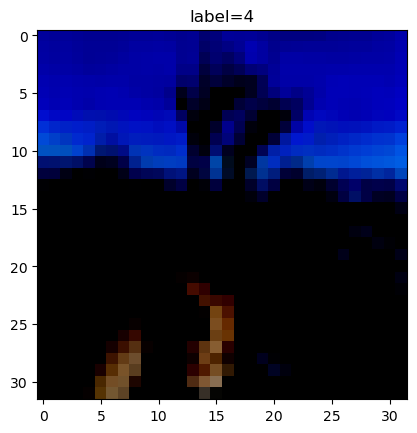

In [4]:
train_features, train_labels = next(iter(cifar_train))
idx = 0
img = train_features[idx]
label = train_labels[idx]
from scipy.stats import describe
print(describe(img.numpy().flatten()))
# img.shape
import matplotlib.pyplot as plt
plt.imshow(img.permute(1,2,0))
plt.title(f'label={label}')
plt.show()

In [6]:
from my_models import * # jupyter notebook很难翻页，所以我们把这些长长的代码扔到py文件里面去
net = ResNet18() # 自己定义的ResNet18
net(img.unsqueeze(0))

tensor([[-0.0670, -0.4149,  0.2728,  0.1976,  0.1658, -0.6658,  0.1142,  0.6912,
          0.9018, -0.0384]], grad_fn=<AddmmBackward0>)

In [21]:
# 多卡训练，防止显存不够
device_ids = list(range(torch.cuda.device_count()))
# device_ids
train_device = torch.device('cuda', device_ids[0]) # 改成2会报错，因为默认主卡是0
# test_device = torch.device('cuda', device_ids[1])
test_device = torch.device('cuda', device_ids[0]) #我服了，pytorch真实垃圾
model = ResNet18()
model = torch.nn.DataParallel(model, device_ids=device_ids)
# torch规定：必须把参数放置在nn.DataParallel中参数device_ids[0]上
model = model.to(train_device)
a = img.unsqueeze(0).to(test_device) # 允许异构
# b = model.to(test_device)
model(a)
model(img.unsqueeze(0)) # 不管数据从哪个卡来，都会自动放到主卡上


tensor([[-0.0144,  0.1964,  0.1886,  0.4437, -1.6326,  0.3999,  0.6308,  1.0715,
          0.4627, -1.1054]], device='cuda:0', grad_fn=<GatherBackward>)

In [24]:
from torch import optim
critiria = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=1e-3)
print(model)

DataParallel(
  (module): ResNet18(
    (conv1): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(3, 3))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (blk1): ResBlock(
      (longcut): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential(
        (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (blk2): ResBlock(
      (longcut): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1

In [13]:
from tqdm import tqdm
from torch import nn
import torch.nn.functional as F

history = {'Train Loss':[],'Test Loss':[],'Test Accuracy':[]}
def test(test_loader, net, critiria):
    correct,totalLoss = 0,0
    totalSize = 0
    net.train(False)
    critiria = critiria.to(test_device)
    for testImgs,labels in test_loader:
        testImgs = testImgs.to(test_device)
        labels = labels.to(test_device)
        outputs = net(testImgs)
        loss = critiria(outputs,labels)
        predictions = torch.argmax(outputs,dim = 1)
        totalSize += labels.size(0)
        totalLoss += loss
        correct += torch.sum(predictions == labels)
    testAccuracy = correct/totalSize
    testLoss = totalLoss/len(test_loader)
    return testLoss,testAccuracy
def train(train_loader, net, critiria, test_loader, n_epochs=5):
    for epoch in range(1, n_epochs + 1):
        try:
            #构建tqdm进度条
            processBar = tqdm(train_loader,unit = 'step')  
            #打开网络的训练模式
            net.train(True)
            critiria = critiria.to(train_device) # 这个critiria会多管闲事，检查数据在不在同一个卡
            
            #开始对训练集的DataLoader进行迭代
            totalTrainLoss = 0.0
            for step,(trainImgs,labels) in enumerate(processBar): # 对一个可以迭代的对象增加进度条
                #将图像和标签传输进device中
                trainImgs = trainImgs.to(train_device)
                labels = labels.to(train_device)
                
                #清空模型的梯度
                optimizer.zero_grad()
                
                #对模型进行前向推理
                outputs = net(trainImgs)
                
                #计算本轮推理的Loss值
                loss = critiria(outputs,labels)
                #计算本轮推理的准确率
                predictions = torch.argmax(outputs, dim = 1)
                accuracy = torch.sum(predictions == labels)/labels.shape[0]
                
                #进行反向传播求出模型参数的梯度
                loss.backward()
                #使用迭代器更新模型权重
                optimizer.step()
                    #将本step结果进行可视化处理
                processBar.set_description("[%d/%d] Loss: %.4f, Acc: %.4f" % 
                                            (epoch,n_epochs,loss.item(),accuracy.item()))
                totalTrainLoss+= loss
                if step == len(processBar)-1:
                # if True:
                    testLoss, testAccuracy = test(test_loader, net, critiria)
                    trainLoss = totalTrainLoss/len(train_loader)
                    history['Train Loss'].append(trainLoss.item())
                    history['Test Loss'].append(testLoss.item())
                    history['Test Accuracy'].append(testAccuracy.item())
                    processBar.set_description("[%d/%d] Loss: %.4f, Acc: %.4f, Test Loss: %.4f, Test Acc: %.4f" % 
                                        (epoch,n_epochs,loss.item(),accuracy.item(),testLoss.item(),testAccuracy.item()))
                processBar.close()
                
        except Exception as e:
            print(e)
        finally:
            print('训练已经中断')
            torch.save(net.state_dict(), f'./checkpoints/cifar_resnet_epoch{epoch}_step{step}.pth')

                

In [31]:
torch.cuda.empty_cache()

In [113]:
!mkdir checkpoints 

mkdir: cannot create directory ‘checkpoints’: File exists


In [119]:
train(cifar_train, model, critiria, cifar_test, n_epochs=100)

[1/100] Loss: 1.8038, Acc: 0.4688:   0%|          | 0/1563 [00:00<?, ?step/s]


训练已经中断


[2/100] Loss: 0.9706, Acc: 0.5625:   0%|          | 0/1563 [00:00<?, ?step/s]


训练已经中断


[3/100] Loss: 0.7518, Acc: 0.7812:   0%|          | 0/1563 [00:00<?, ?step/s]


训练已经中断


[4/100] Loss: 0.7948, Acc: 0.8125:   0%|          | 0/1563 [00:00<?, ?step/s]


训练已经中断


[5/100] Loss: 0.6372, Acc: 0.8125:   0%|          | 0/1563 [00:00<?, ?step/s]


训练已经中断


[6/100] Loss: 0.4199, Acc: 0.8125:   0%|          | 0/1563 [00:00<?, ?step/s]


训练已经中断


[7/100] Loss: 0.3112, Acc: 0.8750:   0%|          | 0/1563 [00:00<?, ?step/s]


训练已经中断


[8/100] Loss: 0.1981, Acc: 0.9062:   0%|          | 0/1563 [00:00<?, ?step/s]


训练已经中断


[9/100] Loss: 0.1552, Acc: 0.9688:   0%|          | 0/1563 [00:00<?, ?step/s]


训练已经中断


[10/100] Loss: 0.0828, Acc: 1.0000:   0%|          | 0/1563 [00:00<?, ?step/s]


训练已经中断


[11/100] Loss: 0.0726, Acc: 1.0000:   0%|          | 0/1563 [00:00<?, ?step/s]


训练已经中断


[12/100] Loss: 0.0400, Acc: 1.0000:   0%|          | 0/1563 [00:00<?, ?step/s]


训练已经中断


[13/100] Loss: 0.1925, Acc: 0.9062:   0%|          | 0/1563 [00:00<?, ?step/s]


训练已经中断


[14/100] Loss: 0.0304, Acc: 1.0000:   0%|          | 0/1563 [00:00<?, ?step/s]


训练已经中断


[15/100] Loss: 0.0356, Acc: 1.0000:   0%|          | 0/1563 [00:00<?, ?step/s]


训练已经中断


KeyboardInterrupt: 

In [22]:
model.load_state_dict(torch.load('checkpoints/cifar_resnet_epoch15_step644.pth'))
model.eval()

DataParallel(
  (module): ResNet18(
    (conv1): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(3, 3))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (blk1): ResBlock(
      (longcut): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential(
        (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (blk2): ResBlock(
      (longcut): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1

In [25]:
testLoss, testAccuracy = test(cifar_test, model, critiria)
testLoss, testAccuracy

(tensor(1.4187, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.7109, device='cuda:0'))

In [5]:
# 下面我们使用预训练模型迁移学习改善模型性能。(开始认真了)
import torchvision
resnet50 = torchvision.models.resnet50(pretrained=True)  # 迁移
# torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True), # 这个写法也可以
print (resnet50)
ct = 0
for child in resnet50.children():
    ct += 1 
    if ct < 7: # 7层之前的参数不更新
        for param in child.parameters():
            param.requires_grad = False 

/home/yecm/anaconda3/envs/torch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yecm/anaconda3/envs/torch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
from torch import nn
model = nn.Sequential(
    resnet50,
    nn.Linear(1000,10),
)
list(model.parameters())[-2].requires_grad
list(model.parameters())[0].requires_grad
model(torch.randn(2,3,32,32))

tensor([[-0.5550,  0.1852, -0.6067,  0.0385, -0.3560, -0.3037, -0.1462,  0.8689,
          0.6516, -1.0485],
        [ 0.7036, -0.8121,  0.2934,  0.2600,  0.9181, -0.2980,  0.2794, -0.4236,
          0.2129,  0.3143]], grad_fn=<AddmmBackward0>)

In [11]:
import my_apis
from torch import optim
model = my_apis.prepare(model)
critiria = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr=1e-3)

In [28]:
my_apis.train(cifar_train, model, critiria, optimizer, cifar_test, n_epochs=100)

[1/100] Loss: 3.4444, Acc: 0.0625:   0%|          | 0/1563 [00:09<?, ?step/s]


训练已经中断


[2/100] Loss: 1.3053, Acc: 0.5938:   0%|          | 0/1563 [00:01<?, ?step/s]


训练已经中断


[3/100] Loss: 1.1674, Acc: 0.5625:   0%|          | 0/1563 [00:00<?, ?step/s]


训练已经中断


[4/100] Loss: 0.5560, Acc: 0.7500:   0%|          | 0/1563 [00:00<?, ?step/s]


训练已经中断


[5/100] Loss: 0.5250, Acc: 0.8438:   0%|          | 0/1563 [00:00<?, ?step/s]


训练已经中断


[6/100] Loss: 0.5503, Acc: 0.8750:   0%|          | 0/1563 [00:00<?, ?step/s]


训练已经中断


[7/100] Loss: 0.6011, Acc: 0.7812:   0%|          | 0/1563 [00:00<?, ?step/s]


训练已经中断


[8/100] Loss: 0.2838, Acc: 0.9062:   0%|          | 0/1563 [00:00<?, ?step/s]


训练已经中断


[9/100] Loss: 0.3484, Acc: 0.9062:   0%|          | 0/1563 [00:00<?, ?step/s]


训练已经中断


[10/100] Loss: 0.6193, Acc: 0.7500:   0%|          | 0/1563 [00:00<?, ?step/s]


训练已经中断


[11/100] Loss: 0.1659, Acc: 0.9375:   0%|          | 0/1563 [00:00<?, ?step/s]


训练已经中断


[12/100] Loss: 0.5601, Acc: 0.8125:   0%|          | 0/1563 [00:00<?, ?step/s]


训练已经中断


[13/100] Loss: 0.1252, Acc: 0.9688:   0%|          | 0/1563 [00:00<?, ?step/s]


训练已经中断


[14/100] Loss: 0.2830, Acc: 0.8750:   0%|          | 0/1563 [00:00<?, ?step/s]


训练已经中断


KeyboardInterrupt: 

In [7]:
# 可以看到13轮结果很好，14轮就开始过拟合了，所以我们可以恢复13轮的模型
model.load_state_dict(torch.load('checkpoints/cifar_resnet_epoch13_step1562.pth'))

<All keys matched successfully>

In [12]:
model = nn.Sequential(
    resnet50,
    nn.Linear(1000,10),
)
model = nn.DataParallel(model, device_ids=[1])
model.load_state_dict(torch.load('checkpoints/cifar_resnet_epoch13_step1562.pth'))

<All keys matched successfully>

In [8]:
with torch.cuda.device('cuda:1'):
    torch.cuda.empty_cache() # pytorch api真的垃圾！！ 一定要这样才能进入device0之外的device


In [13]:
test_device = torch.device('cuda:1')
test_loader = cifar_test
net = model.to(test_device)
print(net)

DataParallel(
  (module): Sequential(
    (0): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace

In [14]:
# del my_apis
import my_apis
my_apis.test(cifar_test, model, critiria, test_device=test_device)

(tensor(0.6210, device='cuda:1', grad_fn=<DivBackward0>),
 tensor(0.8131, device='cuda:1'))

In [ ]:
# 这个还不够。刚才我们迁移学习是加了一层去做，然后锁定了原本的参数。
# 其实还有两种迁移学习方法，一个是把原本resnet的最后一层改了；一个是不锁参数，达到更优。

In [ ]:
# 接下来我们不用迁移学习，直接用resnet50做分类
# 从头开始训练一个小时，看看效果如何

在run_train.py中，我用mindspore实现了一个resnet50的训练。
训练26个epoch，达到了准确率0.96。
效果截图如下
![](./assets/Snipaste_2022-11-16_22-30-20.png)


使用了MindInsight进行可视化，可以看到loss的变化
![](./assets/Snipaste_2022-11-16_22-33-34.png)

In [2]:
# 我们加载第26轮的checkpoint，看看效果
from run_train import *
import mindspore
create_context()
path = 'datasets/cifar-10-batches-bin'
test_loader = create_cifar_dataset(path, False)
network = resnet50(batch_size=batch_size, num_classes=10)
param_dict = load_checkpoint('./checkpoints/ms/CIFAR-10-resnet50-26_937.ckpt')
not_loaded = load_param_into_net(network, param_dict)
ls = SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")
opt = nn.Momentum(filter(lambda x: x.requires_grad, network.get_parameters()), 0.01, 0.9)
model = Model(network, loss_fn=ls, optimizer=opt, metrics={'acc'}, 
                    amp_level='O2',)
model.eval(test_loader)

{'acc': 0.9622701226012793}

### Exercise 2  Questions (5 points )
1. Can neural networks be used for unsupervised clustering or data dimension reduction? Why?

可以用神经网络降维或者聚类。
例如，自编码器：https://zhuanlan.zhihu.com/p/453444431
把输入用NN 编码后再用NN解码，看看是否可以变回原来的数据（作为loss）。
做完之后，就可以去除其中的编码器作为降维器。

聚类当然也是可以做的：https://www.jianshu.com/p/c0d9adae148d， 有相关的论文。
神经网络聚类的好处就是，数据量太大的时候,传统的K-Means可能会很慢，而神经网络聚类可以并行化。
神经网络可以对batch而不是整个数据集进行聚类，这样可以节省内存。



2. What are the strengths of neural networks; when do they perform well?

神经网络的优点是可以自动学习特征，不需要人工去提取特征，而且可以自动学习特征的组合，从而可以自动学习出复杂的特征。当数据量很大的时候，神经网络的表现会很好。
比起朴素贝叶斯、SVM、决策树等，神经网络是比较容易可以被GPU加速的，并行效果比较好。
根据上次寒武纪的讲座，其实陈国良院士也做过这种符号主义的加速的探索，但是最终发现还是对这种联结主义的更好加速。

对了，神经网络还能拟合任何可计算函数，所以假说空间不错。

3. What are the weaknesses of neural networks; when do they perform poorly?

神经网络的缺点是需要大量的训练数据，而且训练时间比较长，消耗大量的算力。
如果数据量不够，可能会过拟合。
可解释性不强，做商业决策的时候，可能会不被采用。




4. What makes neural networks a good candidate for the classification regression problem, if you have enough knowledge about the data?

我知道了足够的数据信息，那就可以用神经网络来做分类回归了。对吧，因为大数据集本来就是神经网络的天下。


### Exercise 3 完成02卷积神经网络\《深度学习》卷积网络实验手册.pdf部分的内容，并把截图提交。（5分）
+ FashionMnist分类任务正则化对比实验结果图



这是没有正则化的网络训练过程：
![](./assets/Snipaste_2022-11-16_22-53-02.png)
这是有正则化的网络训练过程
![](./assets/Snipaste_2022-11-16_23-02-19.png)
从训练loss看不出什么，大概是没有正则化的后期会贴近0，而有正则化会波动，前期都是极速下降。
从accuracy来看，有正则化的acc达到0.92, 而没有正则化的只有0.91。 说明正则化是有一定效果的。
{'acc': 0.9103565705128205}
{'acc': 0.9215745192307693}


除了正则化的作用，我们用TimeMonitor可以发现
Mindspore的数据下沉模式还是很快的，比起一个一个step训练
差不多一个epoch和原来十几个step差不多。

+ LeNet的手写数字识别实验截图

![](./assets/Snipaste_2022-11-16_22-44-40.png)